# Model selection for patient payments

This notebook aims to determine an appropriate model for the copayment prediction.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Since the purpose of this notebook is get a rough understanding on performace of various models, we will not use whole data. Rather, we will use a randomly chosen subset of whole observations of size 10000, which we will save to `pharmacy_sample.csv`.

In [2]:
# df.sample(10000).to_csv("pharmacy_sample.csv")

In [3]:
df = pd.read_csv("pharmacy_sample.csv")

As the rejected claims have zero copayments, we drop the rejected claims.

In [4]:
df = df.loc[df.rejected == False]

We observed in EDA that copayments tend to be higher at the beginning of the year. To reflect this, we create a dummy column, `month`, which assigns 1 in January and 0 in the others.

In [5]:
df = df.assign(month = pd.DatetimeIndex(df["tx_date"]).month)

In [6]:
df.loc[df.month == 1 ,'month'] = 1
df.loc[df.month != 1, 'month'] = 0

As `patient_pay` valeus are highly concentrated in around 0, we apply log function to it.

In [7]:
df =df.assign(log_patient_pay = np.log(df['patient_pay']))

We split the `drug` into `drug_type` and `drug_name`. Also, split `diagonsis` into `diagnosis_broad` and `diagnosis_specific`.

In [8]:
df[["drug_type","drug_name"]] =df['drug'].str.split(" ",expand=True)

In [9]:
df[["diagnosis_broad","diagnosis_specific"]] =df['diagnosis'].str.split(".",expand=True)

We observed that there is a one-to-one correspondence between `pcn` and `group`. Also, if both `pcn` and `group` are `NaN`, its bin is always 571569. Hece we create a column `pcngroup` which encodes `pcn` and `group`.

In [10]:
df = df.assign(pcngroup = df.group)

In [11]:
df['pcngroup'].fillna(df.pcn, inplace = True)

In [12]:
df['pcngroup'].fillna(df.group, inplace = True)
df.loc[df.pcngroup == 571569] = '571569'

Train test split.

In [13]:
df_train, df_test = train_test_split(df.copy(), 
                                            shuffle=True,
                                            random_state=614,
                                            test_size=.2)

We will compare models with respect to various metrics:
- mean_squred_error
- r2_score
- mean_absolute_percentage_error
- mean_absolute_error

In [14]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [15]:
metrics = [mse, r2, mae, mape]

# 1. One-hot encoding

Since all features are categorical, we will create a pipeline for one-hot encoding. In this notebook, we will use four features `month`, `diagnosis_broad`, `drug_type`, `pcngroup` to do a brief comparison of various models.

In [16]:
features = ['month', 'diagnosis_broad', 'diagnosis_specific', 'drug_type', 'drug_name', 'bin', 'pcngroup']

In [17]:
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [18]:
onehot_pipeline = Pipeline([
        ("onehot", sklearn.preprocessing.OneHotEncoder(handle_unknown = "ignore"))
    ])

preprocessing_pipeline = ColumnTransformer([
        ("preprocessor_column", onehot_pipeline, features)
    ])

# 2. Baseline

In [19]:
baseline = np.array([df_train.log_patient_pay.mean()] * len(df_test))

In [20]:
baseline_metric = []

for metric in metrics:
    baseline_metric.append(metric(baseline, df_test.log_patient_pay))

In [21]:
baseline_metric

[0.6738558799121147,
 -3.4168552425516555e+30,
 0.5894790288769524,
 0.21166924812698193]

# 3. Simple Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
slr_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("slr", LinearRegression())
])

In [24]:
slr_pipe.fit(X = df_train[features], 
             y = df_train.log_patient_pay
            )

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('preprocessor_column',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'diagnosis_broad',
                                                   'diagnosis_specific',
                                                   'drug_type', 'drug_name',
                                                   'bin', 'pcngroup'])])),
                ('slr', LinearRegression())])

In [25]:
slr_pipe.predict(df_test[features])

array([3.96893906, 3.13269979, 2.54759119, ..., 3.64589241, 1.58224294,
       2.36569112])

In [26]:
slr_metric = []

for metric in metrics:
    slr_metric.append(metric(slr_pipe.predict(df_test[features]), df_test.log_patient_pay))

# 4. Models with hyperparameters

In the remaining of this notebook, we examine the models with hyperparameters, such as regularized linear regression, k-nearest neighborhood, etc. To do so, we will use GridSearchCV.

In [27]:
from sklearn.model_selection import GridSearchCV

## 4-1. Regularized Linear Regression

In [28]:
from sklearn.linear_model import Lasso

In [29]:
lasso_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("lasso", Lasso())
])

In [30]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

lasso_parameters = [
    {"lasso__alpha": alphas}
]


In [31]:
lasso_gridcv = GridSearchCV(
        estimator = lasso_pipe,
        param_grid = lasso_parameters,
        scoring = "neg_root_mean_squared_error",
        cv = 5)

In [32]:
lasso_gridcv.fit(
    X = df_train[features],
    y = df_train.log_patient_pay
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('preprocessor_column',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'diagnosis_broad',
                                                                          'diagnosis_specific',
                                                                          'drug_type',
                                                                          'drug_name',
                                                                          'bin',
                                                                          'pcn

In [33]:
lasso_gridcv.best_score_

-0.3739610703334889

In [34]:
lasso_gridcv.best_params_

{'lasso__alpha': 0.001}

In [35]:
lasso_metric = []

for metric in metrics:
    lasso_metric.append(metric(lasso_gridcv.predict(df_test[features]), df_test.log_patient_pay))

## 4-2. K-Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
knn_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("knn", KNeighborsRegressor())])

In [38]:
knn_parameters = [1, 5, 10, 15, 20, 25]

knn_grid = [
    {"knn__n_neighbors": knn_parameters,
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]}]

In [39]:
knn_gridcv = GridSearchCV(
        estimator = knn_pipe,
        param_grid = knn_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5)

In [40]:
knn_gridcv.fit(
    X = df_train,
    y = df_train.log_patient_pay
)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('preprocessor_column',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'diagnosis_broad',
                                                                          'diagnosis_specific',
                                                                          'drug_type',
                                                                          'drug_name',
                                                                          'bin',
                                                                          'pcn

In [41]:
knn_gridcv.best_score_

-0.3583555319416919

In [42]:
knn_gridcv.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 10,
 'knn__weights': 'distance'}

In [43]:
knn_metric = []

for metric in metrics:
    knn_metric.append(metric(knn_gridcv.predict(df_test[features]), df_test.log_patient_pay))

## 4-3. Support Vector Machine

In [44]:
from sklearn.svm import SVR

In [45]:
svm_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("svm", SVR())])

In [46]:
svm_parameters = [1, 5, 10, 15, 20, 25]

svm_param_grid = [
    {"svm__kernel": ["linear", "rbf"],
    "svm__C": svm_parameters}
]

In [47]:
svm_gridcv = GridSearchCV(
        estimator = svm_pipe,
        param_grid = svm_param_grid,
        scoring = "neg_root_mean_squared_error")

In [48]:
svm_gridcv.fit(
X = df_train[features],
y = df_train.log_patient_pay)

GridSearchCV(estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('preprocessor_column',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'diagnosis_broad',
                                                                          'diagnosis_specific',
                                                                          'drug_type',
                                                                          'drug_name',
                                                                          'bin',
                                                                          'pcngroup'])])),
      

In [49]:
svm_gridcv.predict(df_test[features])

array([3.79651466, 3.44236381, 2.40811068, ..., 3.67253032, 1.94396285,
       2.47703326])

In [50]:
svm_metric = []

for metric in metrics:
    svm_metric.append(metric(svm_gridcv.predict(df_test[features]), df_test.log_patient_pay))

## 4-4. Ensemble Learning

In this section, we study performaces of ensemble type learning models: Raondom Forest and XGBoost.

### 4-4-1. Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
rf_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("rf", RandomForestRegressor())
])

In [54]:
rf_leafs = [1, 5, 10, 15, 20, 25]

rf_parameters = {
    "rf__min_samples_leaf": rf_leafs
}

In [55]:
rf_gridcv= GridSearchCV(
        estimator = rf_pipe,
        param_grid = rf_parameters,
        scoring = "neg_root_mean_squared_error",
        cv = 5)

In [56]:
rf_gridcv.fit(
    X = df_train[features],
    y = df_train.log_patient_pay)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('preprocessor_column',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'diagnosis_broad',
                                                                          'diagnosis_specific',
                                                                          'drug_type',
                                                                          'drug_name',
                                                                          'bin',
                                                                          'pcn

In [57]:
rf_metric = []

for metric in metrics:
    rf_metric.append(metric(rf_gridcv.predict(df_test[features]), df_test.log_patient_pay))

### 4-4-2. XGBoost

In [58]:
import xgboost

In [59]:
xgb_pipe = Pipeline([
    ("pre", preprocessing_pipeline),
    ("xgb", xgboost.XGBRegressor())
])

In [60]:
learning_rates = [0.1, 0.5, 1]
n_estimators = [10, 100, 500]
xgb_depths = [1, 5, 10, 15, 20]


xgb_parameters = [
    {"xgb__learning_rate": learning_rates,
    "xgb__n_estimators": n_estimators,
    "xgb__max_depth": xgb_depths}
]


In [61]:
xgb_gridcv = GridSearchCV(
    estimator = xgb_pipe,
    param_grid = xgb_parameters,
    scoring = "neg_root_mean_squared_error",
    cv = 5)

In [62]:
xgb_gridcv.fit(
    X = df_train[features],
    y = df_train.log_patient_pay)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('preprocessor_column',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'diagnosis_broad',
                                                                          'diagnosis_specific',
                                                                          'drug_type',
                                                                          'drug_name',
                                                                          'bin',
                                                                          'pcn

In [63]:
xgb_metric = []

for metric in metrics:
    xgb_metric.append(metric(xgb_gridcv.predict(df_test[features]), df_test.log_patient_pay))

# 5. Scores

In [64]:
scores = pd.DataFrame({
    "xgb" : xgb_metric,
    "rf" : rf_metric,
    "svm" : svm_metric,
    "lasso" : lasso_metric,
    "knn" : knn_metric,
    "simple LR" : slr_metric,
    "baseline" : baseline_metric,
    
    
    
    
}, index = ['mse', 'r2', 'mae', 'mape'])

In [65]:
scores = scores.transpose()

<AxesSubplot:ylabel='mse'>

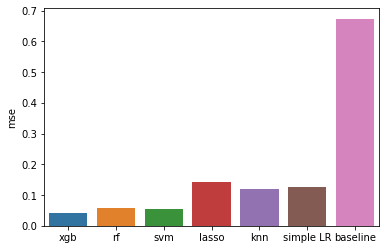

In [70]:
sns.barplot(
data = scores,
y = 'mse',
x = scores.index)

<AxesSubplot:ylabel='r2'>

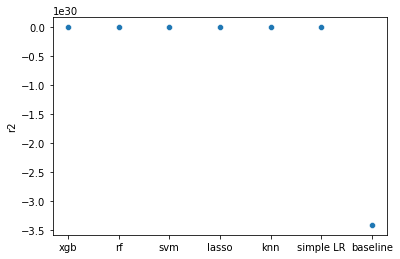

In [72]:
sns.scatterplot(
data = scores,
y = 'r2',
x = scores.index)

<AxesSubplot:ylabel='mae'>

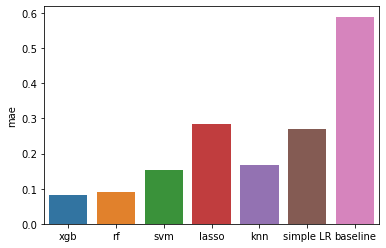

In [73]:
sns.barplot(
data = scores,
y = 'mae',
x = scores.index)

<AxesSubplot:ylabel='mape'>

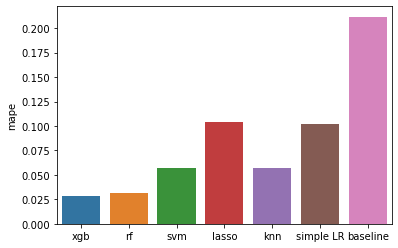

In [74]:
sns.barplot(
data = scores,
y = 'mape',
x = scores.index)

XGBoost perfoms the best.